In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray

In [2]:
def get_points(n: int, interval_x: Tuple[float, float], interval_y: Tuple[float, float]) -> ndarray:
    """

    :param n: number of points to be generated, must be positive
    :param interval_x: interval of coordinate x, must be valid
    :param interval_y: interval of coordinate y, must be valid
    :return: ndarray(n, 2), list of points
    """
    assert len(interval_x) == 2 and interval_x[1] > interval_x[0], "not interval"
    assert len(interval_y) == 2 and interval_y[1] > interval_y[0], "not interval"
    assert n > 0, "number of points must be strict positive"
    x = np.random.rand(1, n)[0] * (interval_x[1] - interval_x[0]) + interval_x[0]
    y = np.random.rand(1, n)[0] * (interval_y[1] - interval_y[0]) + interval_y[0]
    return np.c_[x, y]


get_points(3, (2, 4), (5, 6))

array([[2.92003975, 5.35607389],
       [3.63957871, 5.33955655],
       [2.4073753 , 5.6943719 ]])

In [3]:
negative_points: ndarray = get_points(n=50, interval_x=(0, 45), interval_y=(0, 100))
positive_points: ndarray = get_points(n=50, interval_x=(55, 100), interval_y=(0, 100))
print(negative_points.shape, negative_points[0])
print(positive_points.shape, positive_points[0])

(50, 2) [25.967655   55.07584369]
(50, 2) [99.55208381 87.60604946]


In [4]:
def get_line_neighbors(line: ndarray, neighbors: int, max_step: float = 1) -> List[ndarray]:
    """
    General method of adjusting line for hill-climbing by adding or subtracting x in (0, max_step) for
    a, b and c.

    :param line: must be [[a, b, c]]
    :param neighbors: number of neighboring lines to be generated
    :param max_step: the max difference between any parameter for each neighbor and original line
    :return: List[ndarray(1, 3)], len(list) = neighbors, list of lines
    """
    assert line.shape == (1, 3), f"Not line: {line.shape} != (1,3)"
    assert max_step > 0, "max_step must be positive"
    assert neighbors > 0, "can't generate less than 1 neighbor"
    return [np.random.rand(1, 3) * max_step * 2 - max_step + line for _ in range(neighbors)]


get_line_neighbors(np.array([[1, 2, 3]]), neighbors=5)

[array([[0.33824506, 2.13925989, 2.63410639]]),
 array([[1.96670809, 1.9036794 , 3.32155616]]),
 array([[1.48241639, 2.13440396, 3.13977867]]),
 array([[1.8824645 , 2.06527954, 3.80635999]]),
 array([[0.01973581, 2.85421218, 2.11135979]])]

#### Testing that `-x + 0.033y + 50 = 0` which roughly divides the `x = 50` line also divides the points

[[-1.        ]
 [ 0.03333333]]
50
0


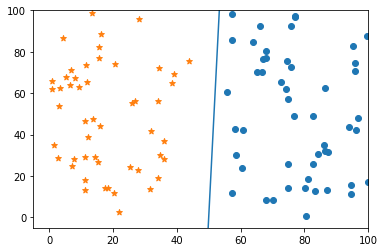

In [5]:
def draw1():
    line = np.array([[-1, 1 / 30, 50]]).reshape(3, 1)
    print(line[:2])
    print(np.count_nonzero(np.dot(negative_points, line[:2]) + 50 > 0))
    print(np.count_nonzero(np.dot(positive_points, line[:2]) + 50 > 0))
    a, b, c = line.reshape(1, 3)[0]
    x = np.linspace(-5, 100, 100)
    y = (-a * x - c) / b
    plt.axis([-5, 100, -5, 100])
    plt.plot(x, y)
    plt.scatter(positive_points[:, 0], positive_points[:, 1], marker="o")
    plt.scatter(negative_points[:, 0], negative_points[:, 1], marker="*")
    plt.show()

draw1()


In [6]:
def get_number_of_points_above_line(line: ndarray, points: ndarray) -> int:
    """

    :param line: must be [[a, b, c]]
    :param points: ndarray(n, 2), list of points
    :return: number of points above (or bellow) the line
    """
    assert line.shape == (1, 3), f"Not line: {line.shape} != (1,3)"
    assert points.shape[1] == 2, f"Not list of points: {points.shape}"
    return np.count_nonzero(np.dot(points, line.reshape(3, 1)[:2]) + line[0, -1:] > 0)


dividing_line = np.array([[-1, 1 / 30, 50]])
print(get_number_of_points_above_line(dividing_line, negative_points))
print(get_number_of_points_above_line(dividing_line, positive_points))

50
0


In [7]:
def init_line() -> ndarray:
    """
    Generating a and b in (-1, 1) gives the best answer.

    :return: [[a, b, c]], a, b in (-10, 10), c in (0, 100)
    """
    line = np.random.rand(1, 3) * 20 - 10
    line[0, 2] = (line[0, 2] + 10) / 20 * 100
    return line


init_line()

array([[6.96692039, 4.75812751, 1.58887461]])

In [8]:
def get_score(line: ndarray) -> int:
    """

    :param line: must be [[a, b, c]]
    :return: how many points are correctly classified by line from all the 100 points
    """
    assert line.shape == (1, 3), f"Not line: {line.shape} != (1,3)"
    return get_number_of_points_above_line(line, negative_points) \
           + 50 - get_number_of_points_above_line(line, positive_points)

In [9]:
def hill_climbing() -> Tuple[ndarray, int]:
    """
    Applies Steepest-Ascent hill-climbing.

    :return: the best line and its score
    """
    line = init_line()
    best_score = 0
    while True:
        best_line = None
        for candidate_line in get_line_neighbors(line, neighbors=10):
            score = get_score(candidate_line)
            if best_score < score:
                best_line = candidate_line
                best_score = score

        if best_line is None:
            break
        else:
            line = best_line

    return line, best_score

hill_climbing()

(array([[-8.87912416, -8.096528  , 65.70247784]]), 50)

In [10]:
def do_hill_climbing(iterations: int = 30, do_print: bool = True):
    best_line = None
    best_score = 0
    for i in range(iterations):
        line, score = hill_climbing()
        if do_print:
            print(f"Iteration {i}:\n\tScore: {score}\n\t"
                  f"Line: {line[0, 0]}x "
                  f"{'+' if line[0, 1] > 0 else '-'} {abs(line[0, 1])}y "
                  f"{'+' if line[0, 2] > 0 else '-'} {abs(line[0, 2])} = 0\n")
        if score > best_score:
            best_score = score
            best_line = line

    return best_line, best_score


do_hill_climbing(5)

Iteration 0:
	Score: 44
	Line: 1.155146291064605x - 7.151502808476345y + 86.36790567467847 = 0

Iteration 1:
	Score: 50
	Line: -9.197091427605304x - 8.904866328854423y + 86.22654398552545 = 0

Iteration 2:
	Score: 50
	Line: 8.574415237739599x + 4.4928567078714305y + 38.32718070004693 = 0

Iteration 3:
	Score: 77
	Line: -5.2564762242527x + 6.664413819724y + 6.916443230814121 = 0

Iteration 4:
	Score: 88
	Line: -4.869382328429498x + 2.5193519603303827y + 30.986596826726835 = 0



(array([[-4.86938233,  2.51935196, 30.98659683]]), 88)

Best score: 100
Best line: -2.4625420231307915x + 0.4150767443106438y + 96.57289302097483 = 0


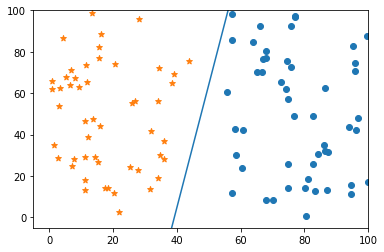

In [11]:
def draw2():
    # For better accuracy, generate a and be between (-1, 1)
    best_line, best_score = do_hill_climbing(do_print=False)
    print(f"Best score: {best_score}")
    print(f"Best line: "
          f"{best_line[0, 0]}x "
          f"{'+' if best_line[0, 1] > 0 else '-'} "
          f"{abs(best_line[0, 1])}y "
          f"{'+' if best_line[0, 2] > 0 else '-'} "
          f"{abs(best_line[0, 2])} = 0")
    a, b, c = best_line[0]
    x = np.linspace(-5, 100, 100)
    y = (-a * x - c) / b
    plt.axis([-5, 100, -5, 100])
    plt.plot(x, y)
    plt.scatter(positive_points[:, 0], positive_points[:, 1], marker="o")
    plt.scatter(negative_points[:, 0], negative_points[:, 1], marker="*")
    plt.show()

draw2()